In [1]:
#import fwiVis.fwiVis as fv
import s3fs
s3 = s3fs.S3FileSystem(anon=False)
from math import cos, asin, sqrt
import re

import numpy as np
import geopandas as gpd
import pandas as pd
from matplotlib import pyplot as plt
import os
import rioxarray as rio
import xarray as xr
import rasterio
import glob
from shapely.errors import ShapelyDeprecationWarning
from shapely.geometry import Point
import warnings
import folium
import datetime
import time
from folium import plugins
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
warnings.filterwarnings("ignore", category=ShapelyDeprecationWarning) 
import contextily as cx
from shapely.geometry import box
import sys
from datetime import datetime, timedelta
from itertools import chain

from datetime import date


sys.path.insert(0, '/projects/old_shared/fire_weather_vis/base-fwi-vis/')
import fwiVis.fwiVis as fv

In [2]:
ciffc = pd.read_csv("/projects/old_shared/fire_weather_vis/Lightning_analysis/CIFFC_data/ciffc_all_canada.csv")
ciffc = ciffc[ciffc.field_agency_code == "qc"]

ciffc = gpd.GeoDataFrame(ciffc, geometry= gpd.points_from_xy(ciffc.field_longitude, ciffc.field_latitude), crs = "4326")
ciffc = ciffc.to_crs("3571")


In [3]:
ciffc.field_response_type.unique()

array(['MOD', 'FUL', 'MON'], dtype=object)

In [4]:

path = "/projects/old_shared/fire_weather_vis/Lightning_analysis/fwi_timeline_merge/Final_dataset_as_of_20240209.csv" 
fire3 = fv.prep_fire_files(path)
fire3 = fire3[~fire3.geometry.isna()]

In [5]:
fire3 = fire3.sort_values(by = ["fireID", "t"])
fire3.farea = fire3.farea.astype("int64")
fire3["farea_diff"] = fire3.groupby("fireID").farea.diff()
fire3["farea_diff_minus1"] = fire3.groupby("fireID").farea.diff(-1)

In [6]:
small = fire3[["fireID", "t", "farea", "FWI", "geometry"]]

In [7]:
small = small.dropna()
small["farea_diff"] = small.groupby("fireID").farea.diff()

Text(0.5, 0, 'FWI')

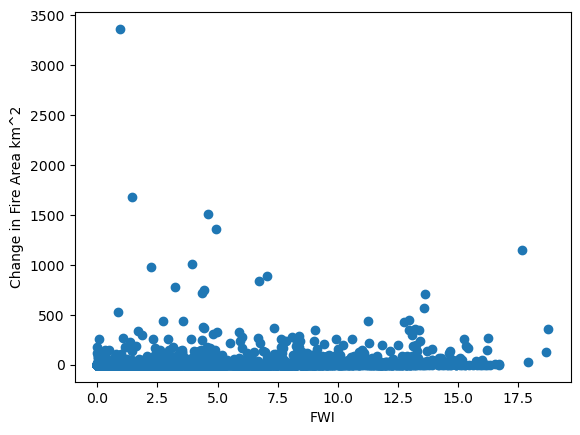

In [8]:
plt.scatter(small.FWI, small.farea_diff)
plt.ylabel("Change in Fire Area km^2")
plt.xlabel("FWI")

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0.5, 0, 'FWI')

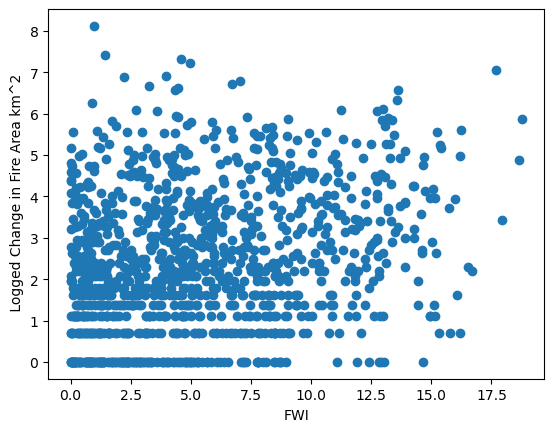

In [9]:
plt.scatter(small.FWI, np.log(small.farea_diff))
plt.ylabel(" Logged Change in Fire Area km^2")
plt.xlabel("FWI")

In [10]:
## Spatial merge with CIFFC
fire3 = fire3.sjoin(ciffc)

In [11]:
ciffc.field_response_type.unique()

array(['MOD', 'FUL', 'MON'], dtype=object)

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


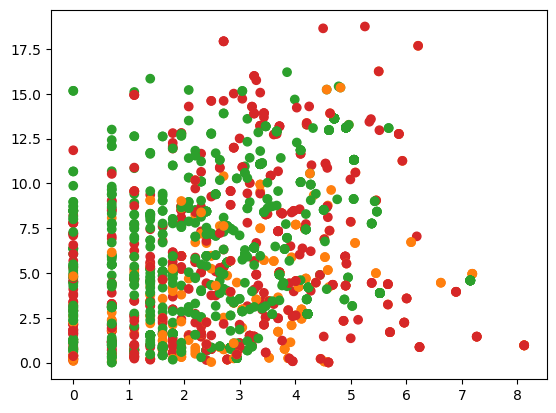

In [12]:
colors = {'MOD':'tab:orange', 'FUL':'tab:green', 'MON':'tab:red'}

plt.scatter(np.log(fire3.farea_diff), fire3.FWI, c = fire3.field_response_type.map(colors))

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


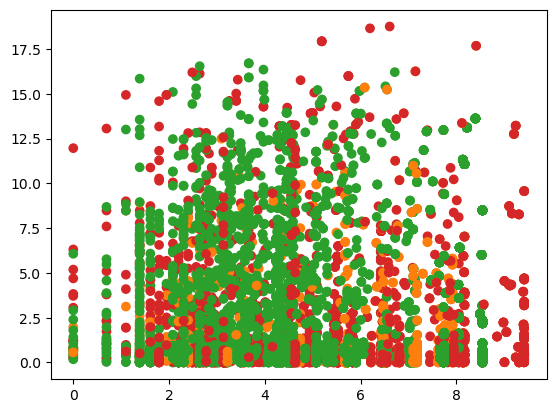

In [13]:
plt.scatter(np.log(fire3.farea), fire3.FWI, c = fire3.field_response_type.map(colors))

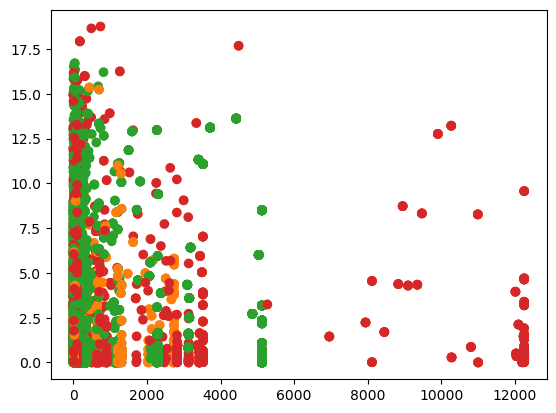

In [14]:
plt.scatter(fire3.farea, fire3.FWI, c = fire3.field_response_type.map(colors))

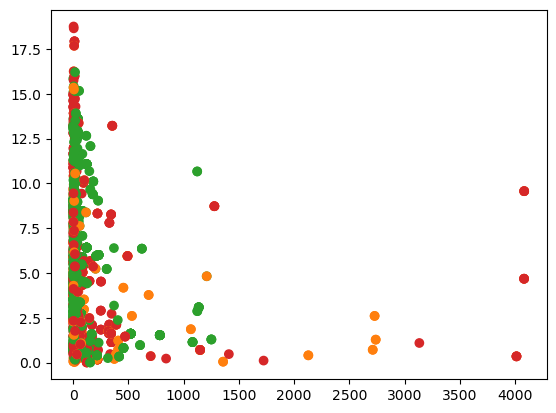

In [15]:
plt.scatter((fire3.farea/fire3.farea_diff), fire3.FWI, c = fire3.field_response_type.map(colors))

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


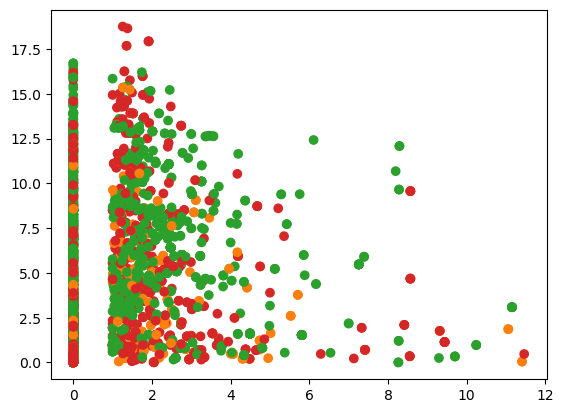

In [16]:
plt.scatter((np.log(fire3.farea)/np.log(fire3.farea_diff)), fire3.FWI, c = fire3.field_response_type.map(colors))

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


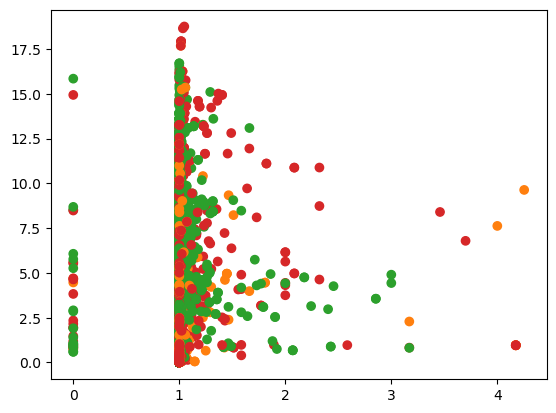

In [17]:
plt.scatter((np.log(fire3.farea)/np.log(fire3.farea-fire3.farea_diff)), fire3.FWI, c = fire3.field_response_type.map(colors))

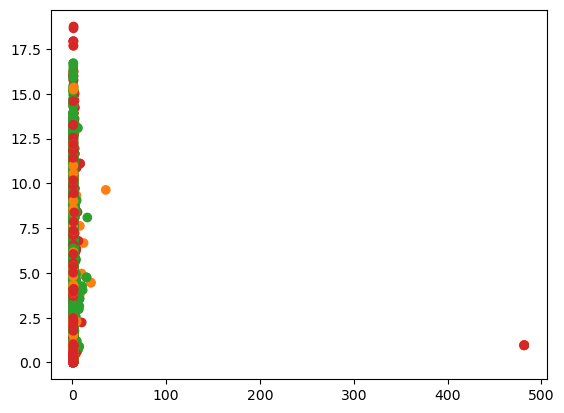

In [18]:
plt.scatter((fire3.farea/(fire3.farea-fire3.farea_diff)), fire3.FWI, c = fire3.field_response_type.map(colors))

In [19]:
fire3 = fire3.sort_values(by = ["fireID", "t"])
fire3.fireID = fire3.fireID.astype("str")
shifted = fire3.groupby(["fireID"]).farea.shift(1)
fire3["farea_shifted1"] = shifted

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


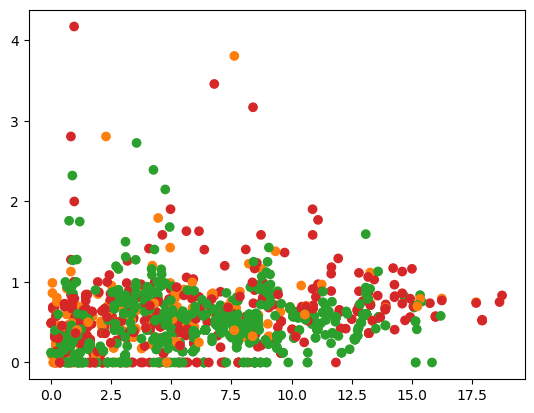

In [20]:
small = fire3[["fireID", "t", "farea", "FWI", "geometry", "field_response_type", "farea_shifted1", 'farea_diff']]
small = small.dropna()

plt.scatter( small.FWI, np.log(small.farea_diff)/np.log(small.farea_shifted1), c = small.field_response_type.map(colors))

In [21]:


small["relative_area_change"] = small.farea_diff/small.farea_shifted1

small = small[~(small.relative_area_change > 1000000000)]

In [22]:
import statsmodels.api as sm
import matplotlib.pyplot as plt
import statsmodels.formula.api as smf

In [23]:
## Try to see if there is a linear difference

#small = small[small.relative_area_change > 0]
#small

In [24]:
model = smf.glm(formula = "relative_area_change ~ FWI", data = small, family = sm.families.Poisson())

In [25]:
print(model.fit().summary())

                  Generalized Linear Model Regression Results                   
Dep. Variable:     relative_area_change   No. Observations:                 6795
Model:                              GLM   Df Residuals:                     6793
Model Family:                   Poisson   Df Model:                            1
Link Function:                      Log   Scale:                          1.0000
Method:                            IRLS   Log-Likelihood:                -5519.7
Date:                  Fri, 09 Feb 2024   Deviance:                       10064.
Time:                          11:09:06   Pearson chi2:                 1.82e+06
No. Iterations:                       8   Pseudo R-squ. (CS):           0.004672
Covariance Type:              nonrobust                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
Intercept     -2.1005      0.042

-2


/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


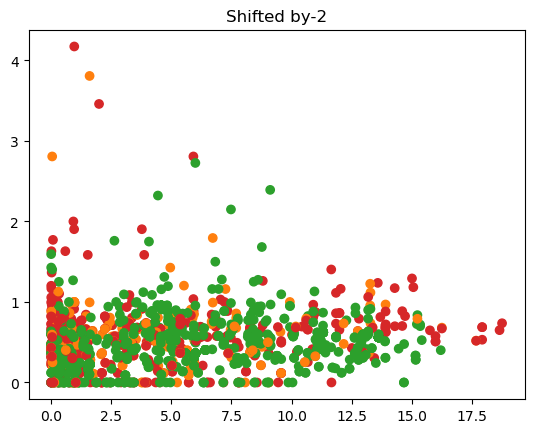

-1


/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


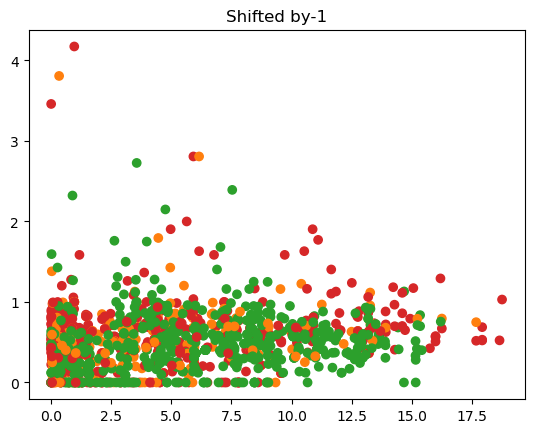

0


/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


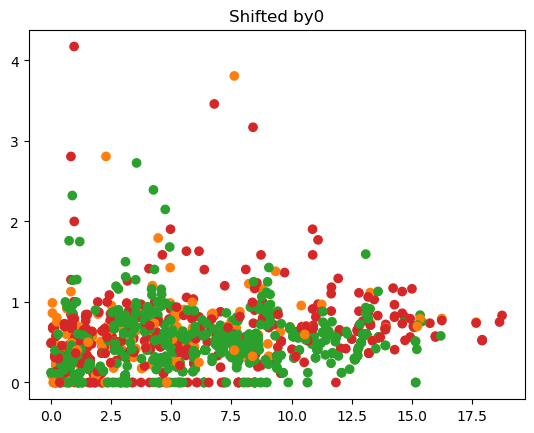

1


/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


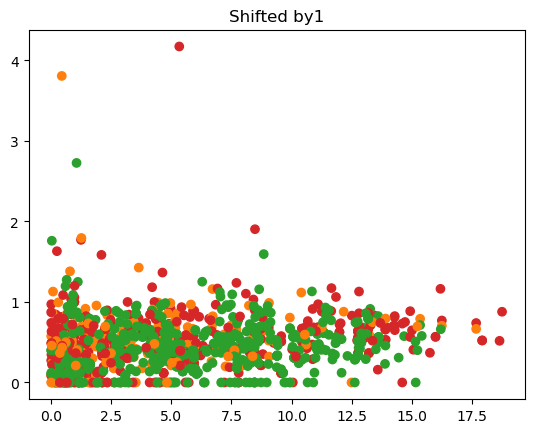

In [26]:
## Maybe it's the FWI of the day before?

for i in range(-2, 2):
    print(str(i))
    shift_FWI = small.groupby(["fireID"]).FWI.shift(i)
    small["FWI_shift1"] = shift_FWI
    plt.scatter( small.FWI_shift1, np.log(small.farea_diff)/np.log(small.farea_shifted1), c = small.field_response_type.map(colors))
    plt.title("Shifted by" + str(i))
    plt.show()
    

-2


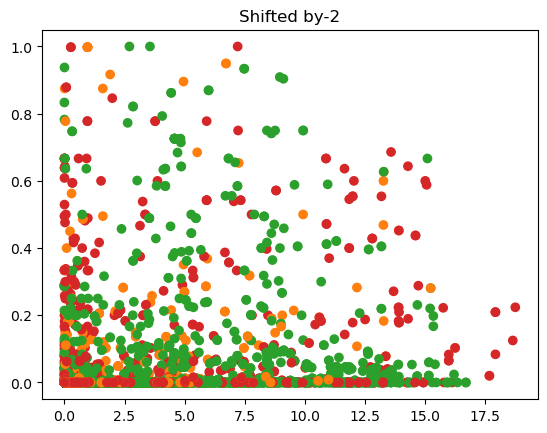

-1


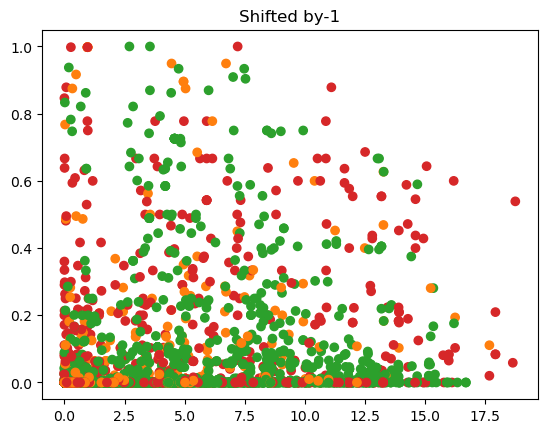

0


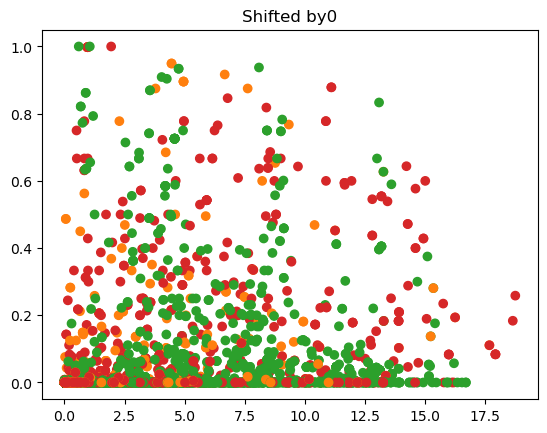

1


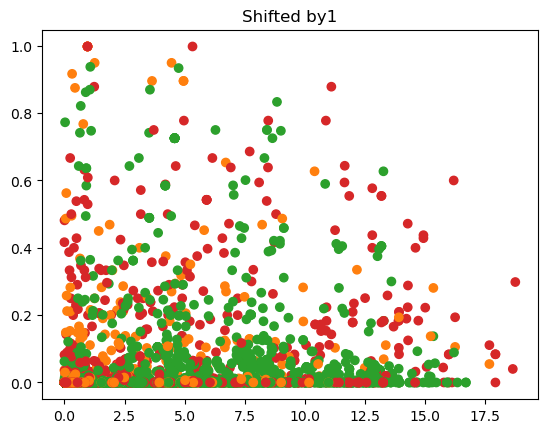

In [27]:
for i in range(-2, 2):
    print(str(i))
    shift_FWI = small.groupby(["fireID"]).FWI.shift(i)
    small["FWI_shift1"] = shift_FWI
    plt.scatter( small.FWI_shift1, small.farea_diff/small.farea, c = small.field_response_type.map(colors))
    plt.title("Shifted by" + str(i))
    plt.show()

In [28]:
### Check for relationships at the extreames -- ie max area growth
max_diff_growth = small.groupby(["fireID"]).farea_diff.max()
max_diff_growth = max_diff_growth.reset_index()
max_diff_growth

,fireID,farea_diff
0,10013,4.0
1,10056,98.0
2,10147,0.0
3,10286,486.0
4,10406,213.0
...,...,...
145,9612,72.0
146,9791,123.0
147,9837,51.0
148,9843,148.0


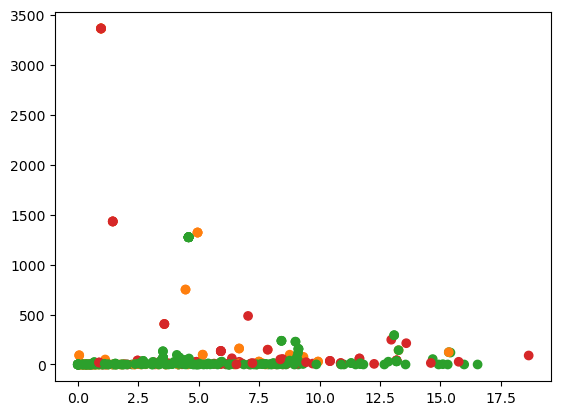

In [29]:
tmp = small.merge(max_diff_growth.rename(columns={"farea_diff": "farea_diff_max"}), on = ["fireID"])
#tmp

#small["max_diff_growth"] = max_diff_growth
#small.max_diff_growth.unique()


plt.scatter( tmp[tmp.farea_diff == tmp.farea_diff_max].FWI, tmp[tmp.farea_diff == tmp.farea_diff_max].farea_diff, c = tmp[tmp.farea_diff == tmp.farea_diff_max].field_response_type.map(colors))

In [30]:
small.columns

Index(['fireID', 't', 'farea', 'FWI', 'geometry', 'field_response_type',
       'farea_shifted1', 'farea_diff', 'relative_area_change', 'FWI_shift1'],
      dtype='object')

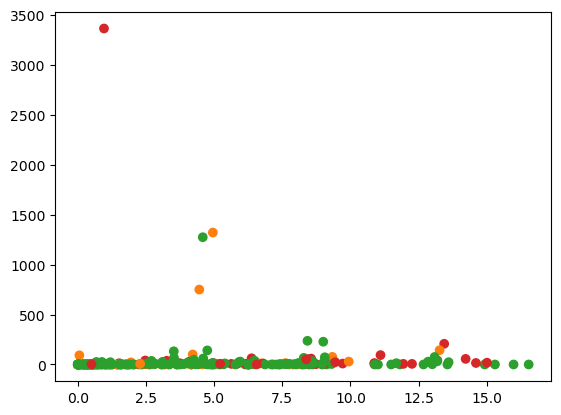

In [31]:
max_diff_growth = small.groupby(["fireID"]).relative_area_change.max()
max_diff_growth = max_diff_growth.reset_index()
max_diff_growth

tmp = small.merge(max_diff_growth.rename(columns={"relative_area_change": "farea_diff_max"}), on = ["fireID"])
plt.scatter( tmp[tmp.relative_area_change == tmp.farea_diff_max].FWI, tmp[tmp.relative_area_change == tmp.farea_diff_max].farea_diff, c = tmp[tmp.relative_area_change == tmp.farea_diff_max].field_response_type.map(colors))

Text(0.5, 0, 'FWI')

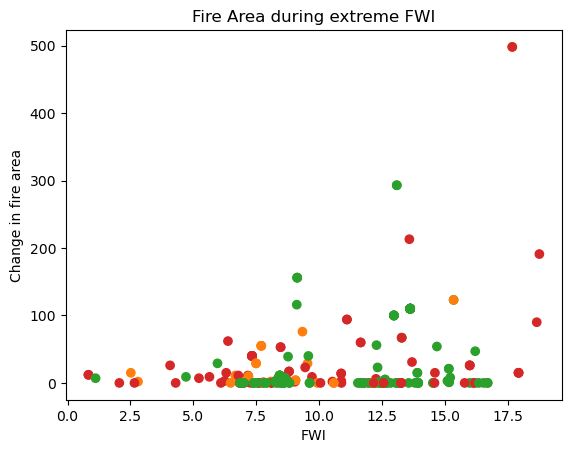

In [32]:
max_diff_growth = small.groupby(["fireID"]).FWI.max()
max_diff_growth = max_diff_growth.reset_index()
max_diff_growth

tmp = small.merge(max_diff_growth.rename(columns={"FWI": "FWI_max"}), on = ["fireID"])
scatter = plt.scatter( tmp[tmp.FWI == tmp.FWI_max].FWI, tmp[tmp.FWI == tmp.FWI_max].farea_diff, c = tmp[tmp.FWI == tmp.FWI_max].field_response_type.map(colors))
plt.title("Fire Area during extreme FWI")
plt.ylabel("Change in fire area")
plt.xlabel("FWI")


/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log
  result = getattr(ufunc, method)(*inputs, **kwargs)


Text(0, 0.5, 'log Change in fire area')

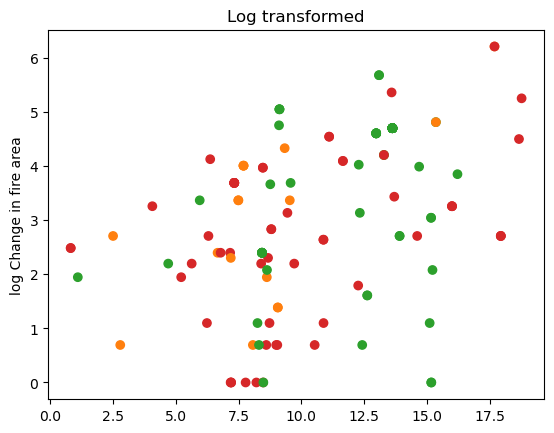

In [33]:
plt.scatter( tmp[tmp.FWI == tmp.FWI_max].FWI, np.log(tmp[tmp.FWI == tmp.FWI_max].farea_diff), c = tmp[tmp.FWI == tmp.FWI_max].field_response_type.map(colors))
plt.title("Log transformed")
plt.ylabel("log Change in fire area")

In [34]:
### I try cleanign the plots up using a ggplot knockoff

from plotnine import ggplot, geom_point, geom_jitter, aes, stat_smooth, facet_wrap
import plotnine as plotnine

/projects/myenvs/fireatlas_oct4/lib/python3.11/site-packages/pandas/core/arraylike.py:396: RuntimeWarning: divide by zero encountered in log


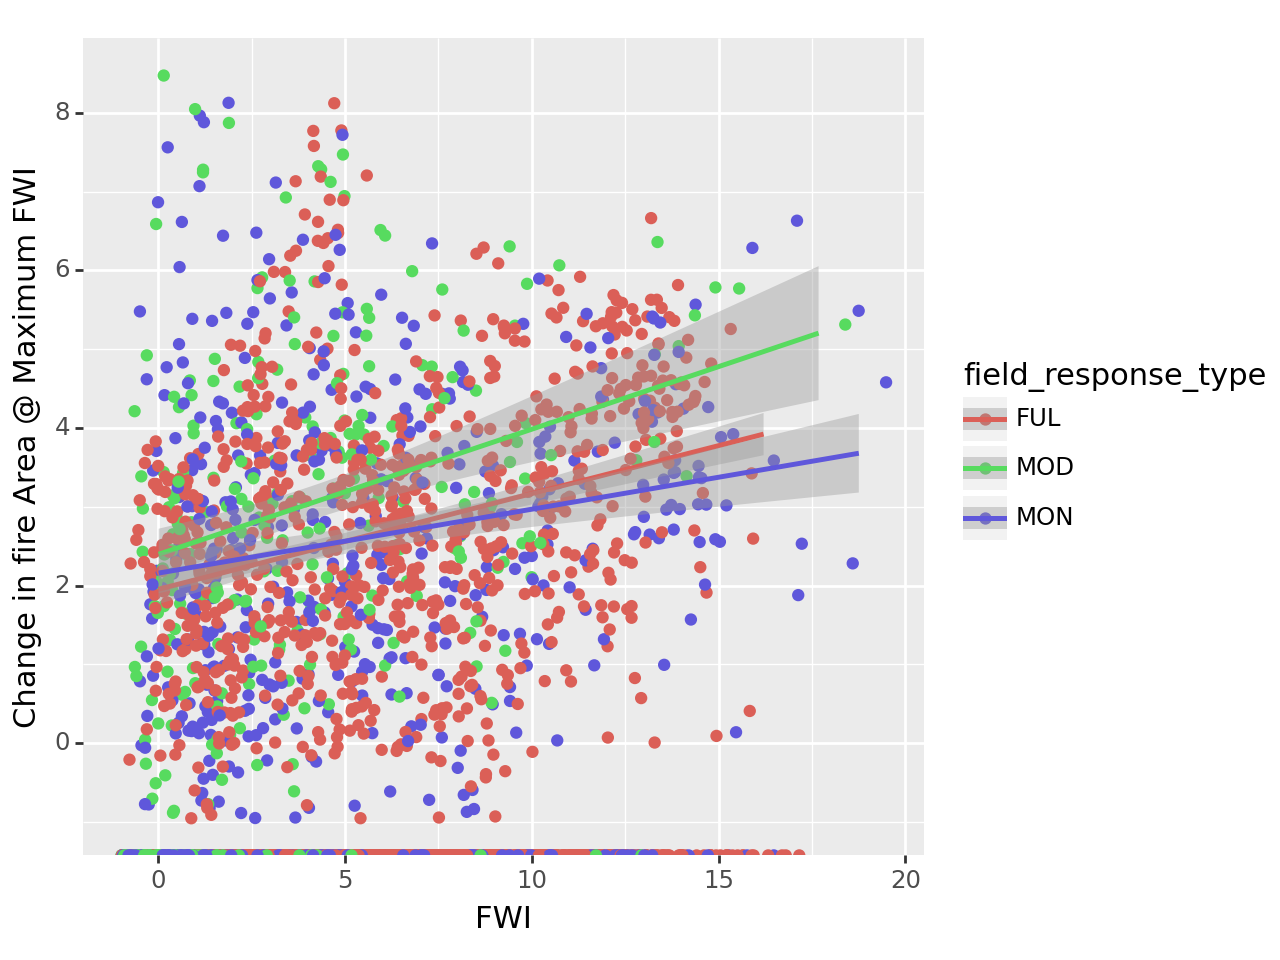

<Figure Size: (640 x 480)>

In [35]:
(ggplot(small, aes("FWI", np.log(small.farea_diff), color = "field_response_type"))
 + geom_jitter(width = 1, height = 1)
 + plotnine.labels.ylab("Change in fire Area @ Maximum FWI")
 + plotnine.labels.xlab("FWI")
 + stat_smooth(method = "lm")
    
)

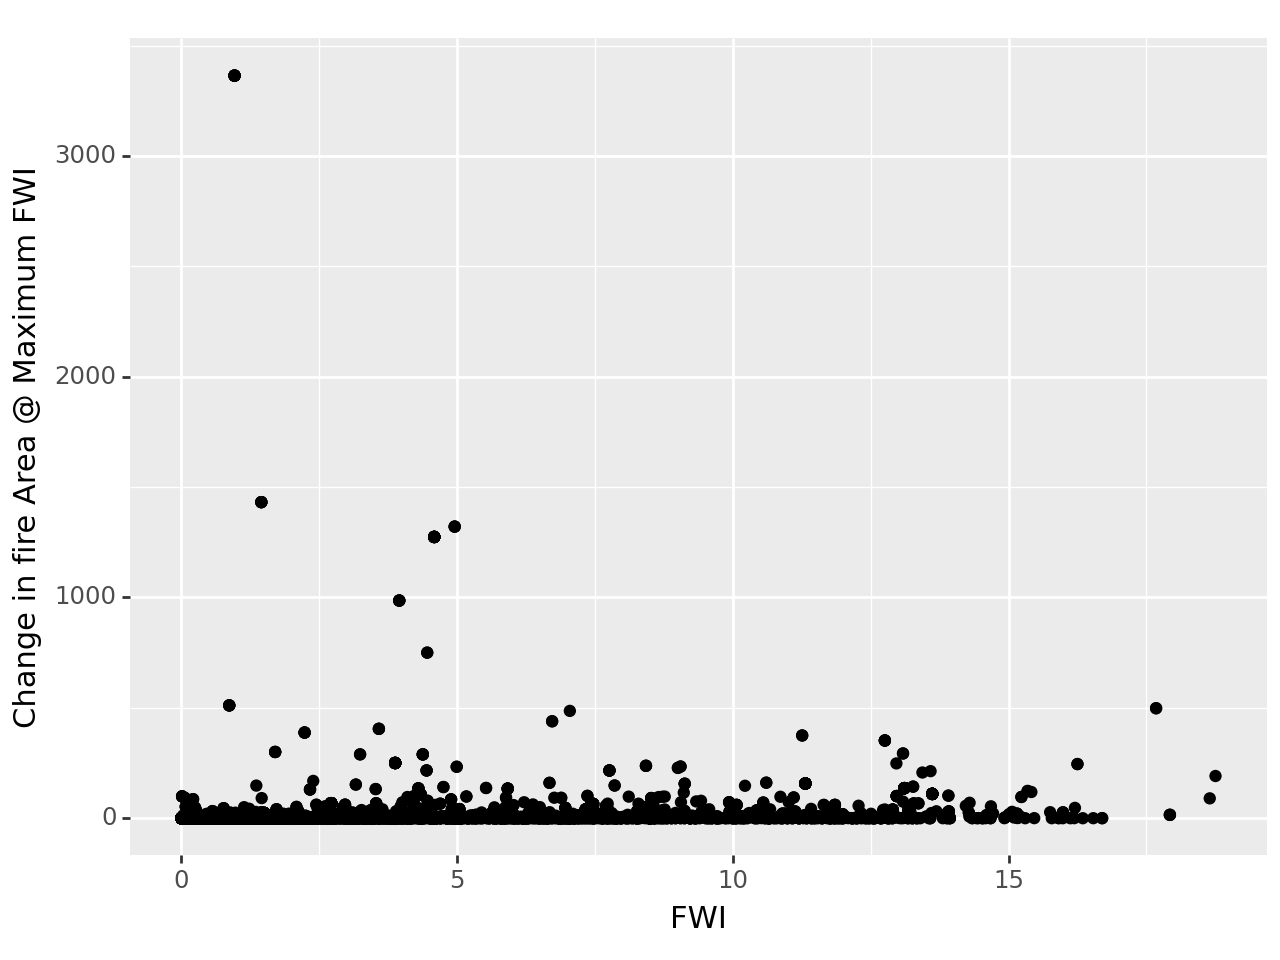

<Figure Size: (640 x 480)>

In [36]:
(ggplot(small, aes("FWI", small.farea_diff))
 + geom_jitter()
 + plotnine.labels.ylab("Change in fire Area @ Maximum FWI")
 + plotnine.labels.xlab("FWI")
 #+ stat_smooth(method = "lm")
    
)

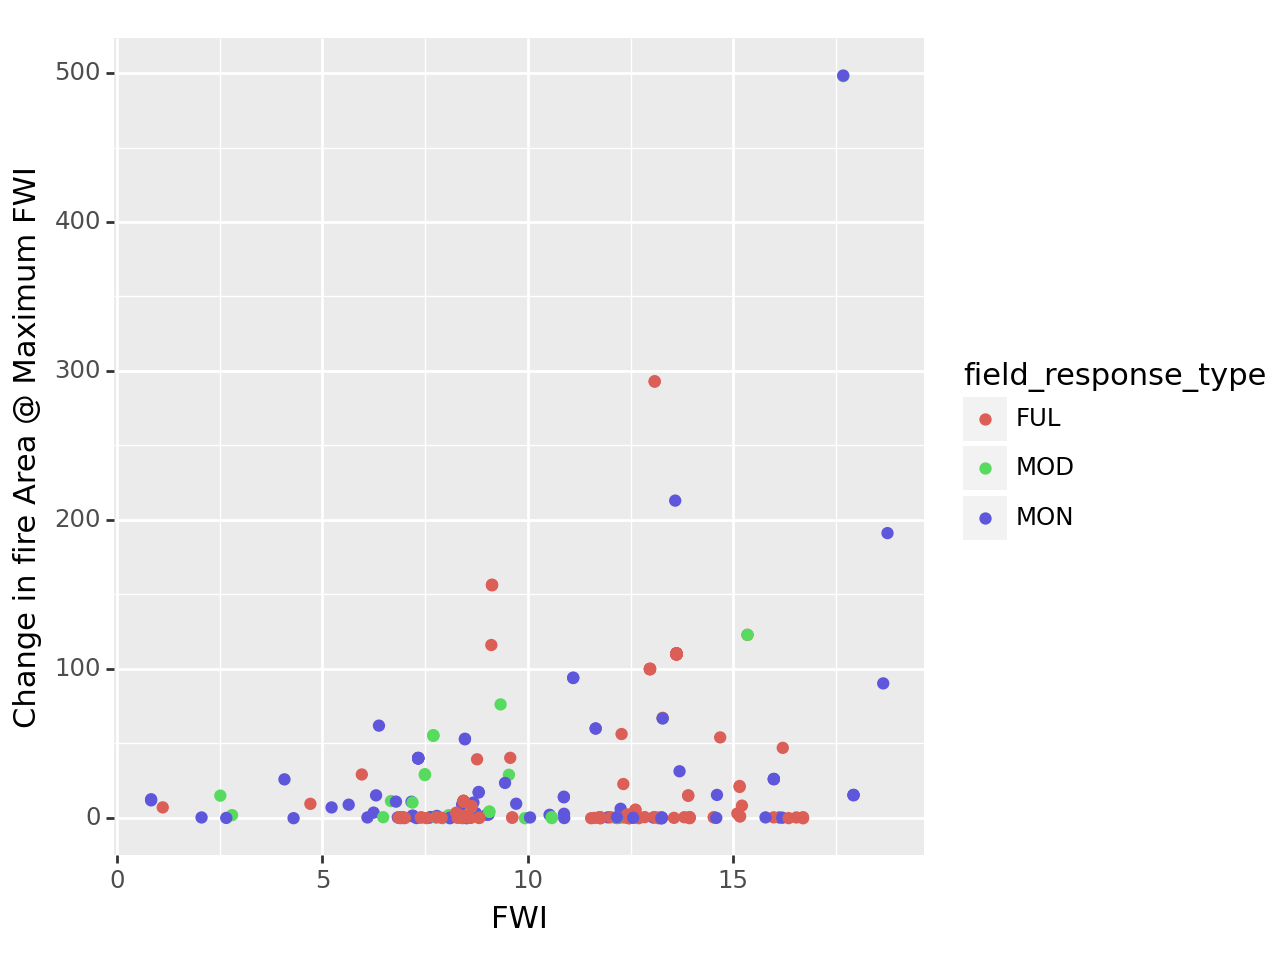

<Figure Size: (640 x 480)>

In [37]:

(ggplot(tmp[tmp.FWI == tmp.FWI_max], aes("FWI", "farea_diff", color = "field_response_type"))
 #+ geom_jitter(width = 1, height = 1)
 + geom_jitter()
 + plotnine.labels.ylab("Change in fire Area @ Maximum FWI")
 #+ stat_smooth(method = "lm")
)
 #+ stat_smooth(method = "wls"))

    

In [38]:
tmp[(tmp.FWI == tmp.FWI_max) & (tmp.farea_diff > 400)]

,fireID,t,farea,FWI,geometry,field_response_type,farea_shifted1,farea_diff,relative_area_change,FWI_shift1,FWI_max
3706,8495,2023-06-22 12:00:00.000,4492,17.675819,"MULTIPOLYGON (((3912634.000 1049087.459, 39126...",MOD,3994.0,498.0,0.124687,13.365473,17.675819
3707,8495,2023-06-22 12:00:00.000,4492,17.675819,"MULTIPOLYGON (((3912634.000 1049087.459, 39126...",MON,4492.0,498.0,0.110864,17.675819,17.675819


In [39]:
fire3[(fire3.fireID == '8495')].field_agency_fire_id.unique()

array(['218', '219', '485', '516'], dtype=object)

In [41]:
#fire_samp[["fireID", "t", "farea", "farea_diff", "farea_shift2", "shift"]][fire_samp.fireID.isin(['10373', '10406'])]

In [42]:
#fire3.groupby(['fireID']).farea.max()

In [ ]:
#fire3.groupby(["fireID", "t"]).farea.m

In [ ]:
#fire3.farea.shift(1)